# Case Study on Financial Crsisis

In [40]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install yfinance
!{sys.executable} -m pip install requests 
!{sys.executable} -m pip install datetime
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install pandas
!pip install bootstrap-stat
!pip install copulae
!pip install arch
!pip install -U seaborn

  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0


In [41]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime 
import requests
import scipy
from IPython.display import display, HTML, display_html
from bootstrap_stat import bootstrap_stat as bp
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.metrics import r2_score, accuracy_score
from sklearn import tree
from sklearn import svm
import itertools
from scipy.stats import shapiro
from scipy.stats import probplot
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import random
import pandas.util.testing as tm
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from arch import arch_model
from math import sqrt
from collections import OrderedDict
import pylab


import warnings
warnings.filterwarnings('ignore')

# 1. Data Importing
## 1.1 Choose a financial crisis of the last 100 years.  Be sure that you can find data for the crisis you select.  (Otherwise, select a different crisis)

We will be choosing the 2008 finanical crisis, also known as the great recession (will be expanding from this link: https://en.wikipedia.org/wiki/Causes_of_the_Great_Recession). 

## 1.2 Identify the key market factors

[Expand from the above wiki link]

# 2. Data Processing
## 2.1 Find at least 5 securities, macroeconomic indicators, or other factors that were signficantly affected by the crisis.

Because the financial crisis began due to the mismanagement of the risk factors pertaining to the packaging of subprime mortgages; we shall take five banking corporation stocks for our assessment purposes.


## 2.2 Be sure to collect data that starts 6 months prior to the crisis, and goes 6 months after the crisis.

Since the peak of the great recession is termed to be from and around September 2008, we shall take the months of september 2008, october 2008, november 2008, december 2008, januart 2009, and february 2009; as the post six months since the crisis first began.

The months of march 2008, april 2008, may 2008, june 2008, july 2008, and august 2008; as the pre six months since the crisis first began.

## 2.3 Download them into python

In [3]:
# Dataframe having list of stocks with their ticker symbols
stocklist = pd.DataFrame([['Bank of America', 'BAC'], ['CitiGroup','C'], ['Goldman Sachs', 'GS'], ['JPMorgan Chase', 'JPM'],
                                  ['Morgan Stanley','MS'], ['Wells Fargo','WFC']], columns= ['stock','symbol'])
stocklist


,stock,symbol
0,Bank of America,BAC
1,CitiGroup,C
2,Goldman Sachs,GS
3,JPMorgan Chase,JPM
4,Morgan Stanley,MS
5,Wells Fargo,WFC


In [4]:
start_date = datetime.datetime(2008, 3, 1)
end_date = datetime.datetime(2009, 2, 28)

# using the banks as the five securities 

symbols = ['BAC', 'C', 'GS', 'JPM', 'MS', 'WFC']

data = pd.DataFrame()

for sym in symbols: 
  try: 
    fund = []
    fund = yf.download(sym, start = start_date, end = end_date, progress = True)
    if (len(fund) == 0):
        None
    else:
        fund['Name'] = sym
        data = data.append(fund, sort = False)
  except Exception:
    None


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## 2.4 Be sure to align their frequencies (e.g. some may be daily, some may be quarterly)

The frequences are all daily as can be seen

In [5]:
data

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2008-02-29,41.020000,41.070000,39.540001,39.740002,31.843462,39711500,BAC
2008-03-03,39.740002,39.959999,38.570000,39.180000,31.394745,37261500,BAC
2008-03-04,38.759998,39.090000,37.779999,38.779999,31.074224,46582400,BAC
2008-03-05,38.650002,38.730000,37.209999,37.549999,30.593515,51850800,BAC
2008-03-06,36.950001,37.230000,36.279999,36.520000,29.754347,51961200,BAC
...,...,...,...,...,...,...,...
2009-02-23,11.760000,12.950000,10.560000,11.030000,8.092710,225178200,WFC
2009-02-24,11.390000,13.110000,11.150000,13.050000,9.574782,187177900,WFC
2009-02-25,12.960000,14.080000,11.770000,13.440000,9.860929,209935600,WFC


## 2.5 Also, compute their returns.  It is at your discreation if your returns are daily, weekly, or monthly.

We shall be computing the **daily** returns

In [6]:
df = data[['Adj Close', 'Name']].pivot(columns='Name') 
df.columns = df.columns.droplevel(0)
returns = df.pct_change().dropna()

logreturns = np.log1p(df.pct_change()).dropna() 
#returns = np.log2(df).diff().dropna()

display(returns)

Name,BAC,C,GS,JPM,MS,WFC
Date,,,,,,
2008-03-03,-0.014091,-0.026150,-0.026823,-0.020418,-0.012820,-0.012316
2008-03-04,-0.010209,-0.042876,-0.008965,-0.015822,-0.005532,-0.001385
2008-03-05,-0.015470,0.002262,0.008373,-0.011482,0.002902,0.005203
2008-03-06,-0.027430,-0.044244,-0.038309,-0.035364,-0.043405,-0.039683
2008-03-07,0.006024,-0.012281,0.008950,0.005084,0.004789,0.010061
...,...,...,...,...,...,...
2009-02-23,0.031662,0.097436,-0.053434,-0.019598,-0.031395,0.010999
2009-02-24,0.209719,0.214953,0.161234,0.077396,0.172689,0.183137
2009-02-25,0.090909,-0.030769,-0.032910,0.033778,-0.014046,0.029885


Name,BAC,C,GS,JPM,MS,WFC
Date,,,,,,
2008-03-03,-0.014091,-0.026150,-0.026823,-0.020418,-0.012820,-0.012316
2008-03-04,-0.010209,-0.042876,-0.008965,-0.015822,-0.005532,-0.001385
2008-03-05,-0.015470,0.002262,0.008373,-0.011482,0.002902,0.005203
2008-03-06,-0.027430,-0.044244,-0.038309,-0.035364,-0.043405,-0.039683
2008-03-07,0.006024,-0.012281,0.008950,0.005084,0.004789,0.010061


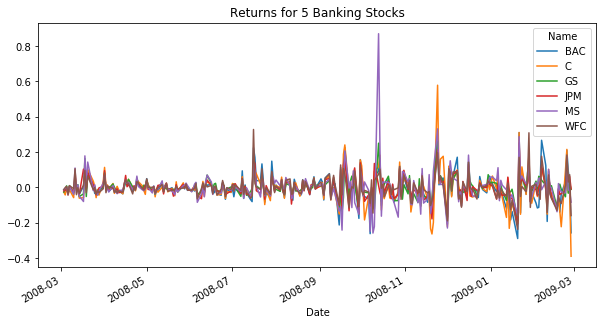

In [7]:
returns.plot(figsize=(10, 5), title='Returns for 5 Banking Stocks')
returns.head()

# 3. Visualizing data
## 3.1 Graph them using at least 3 different EDA plots.  Possibilities include density plots, box plots, qq plots, Tukey-mean difference plots, conditional plots

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D2B9E9B6C8>,
      dtype=object)

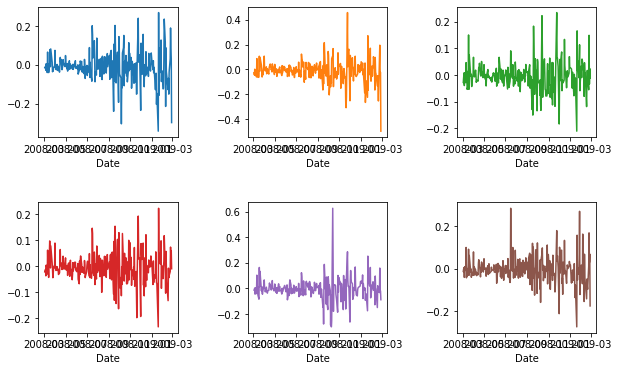

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
target1 = [axes[0][0], axes[0][1], axes[0][2], axes[1][0], axes[1][1], axes[1][2]]

logreturns.plot(subplots=True, ax=target1, legend=False, sharex=False, sharey=False)

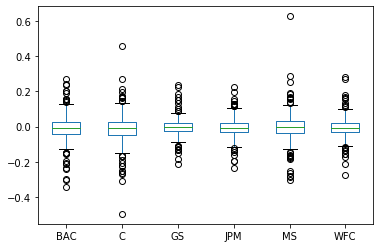

In [9]:
logreturns.plot(kind = 'box')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D2BA24B308>,
      dtype=object)

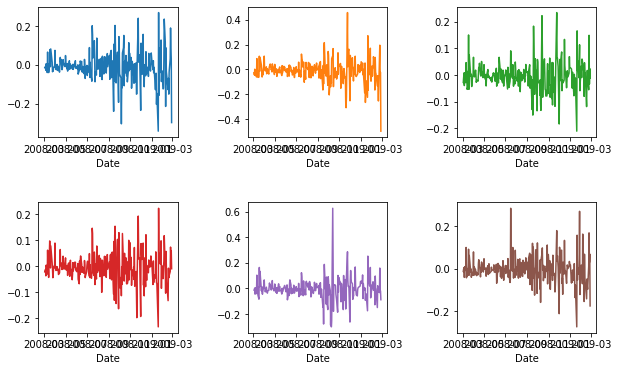

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
target1 = [axes[0][0], axes[0][1], axes[0][2], axes[1][0], axes[1][1], axes[1][2]]

logreturns.plot(subplots=True, ax=target1, legend=False, sharex=False, sharey=False)

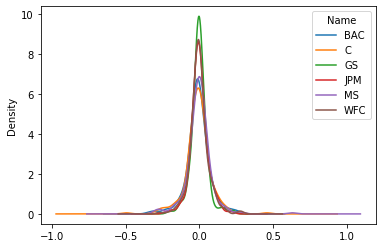

In [11]:
logreturns.plot(kind = 'density')

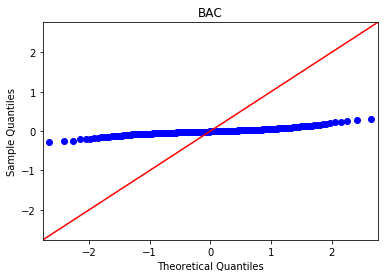

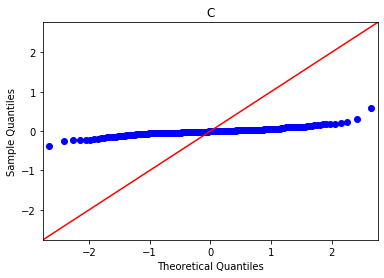

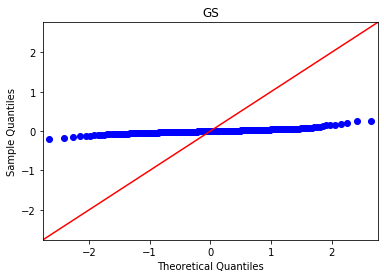

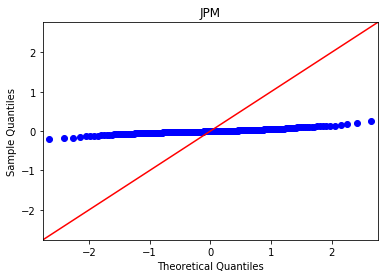

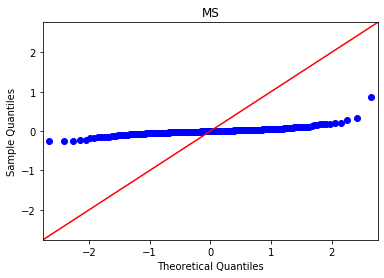

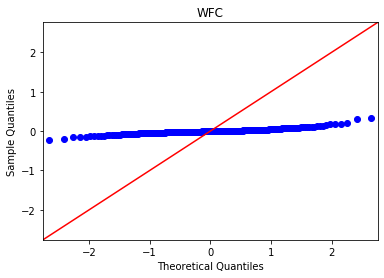

In [12]:
for idx, col in enumerate(returns.columns):
  sm.qqplot(returns[col], line='45')
  pylab.title(col)
  pylab.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D2BD5E5108>,
      dtype=object)

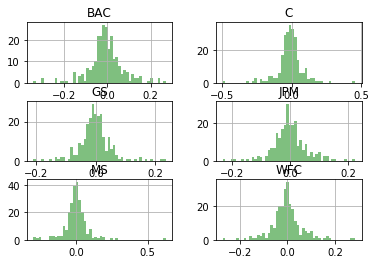

In [13]:
logreturns.hist(color="g", alpha=0.5, bins=50)

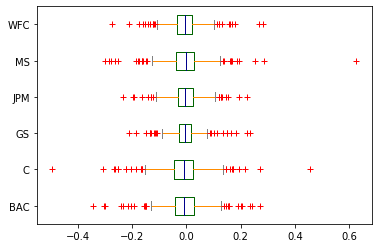

In [14]:
color = {"boxes": "DarkGreen", "whiskers": "DarkOrange", "medians": "DarkBlue", "caps": "Gray", }
logreturns.plot.box(color=color, sym="r+",vert=False)

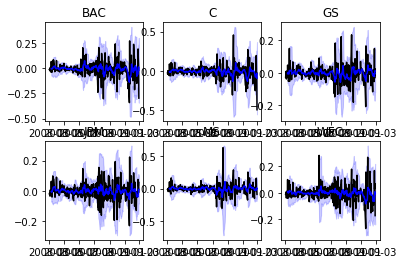

In [15]:
for idx, col in enumerate(logreturns.columns):
  ax = plt.subplot(2, 3, idx + 1)
  tmp_df = logreturns[col]
  ma = tmp_df.rolling(7).mean()
  mstd = tmp_df.rolling(7).std()
 
  ax.plot(tmp_df.index, tmp_df, "k")
  ax.plot(ma.index, ma, "b")
  ax.fill_between(mstd.index, ma - 2 * mstd, ma + 2 * mstd, color="b", alpha=0.2)
  ax.set_title(col)

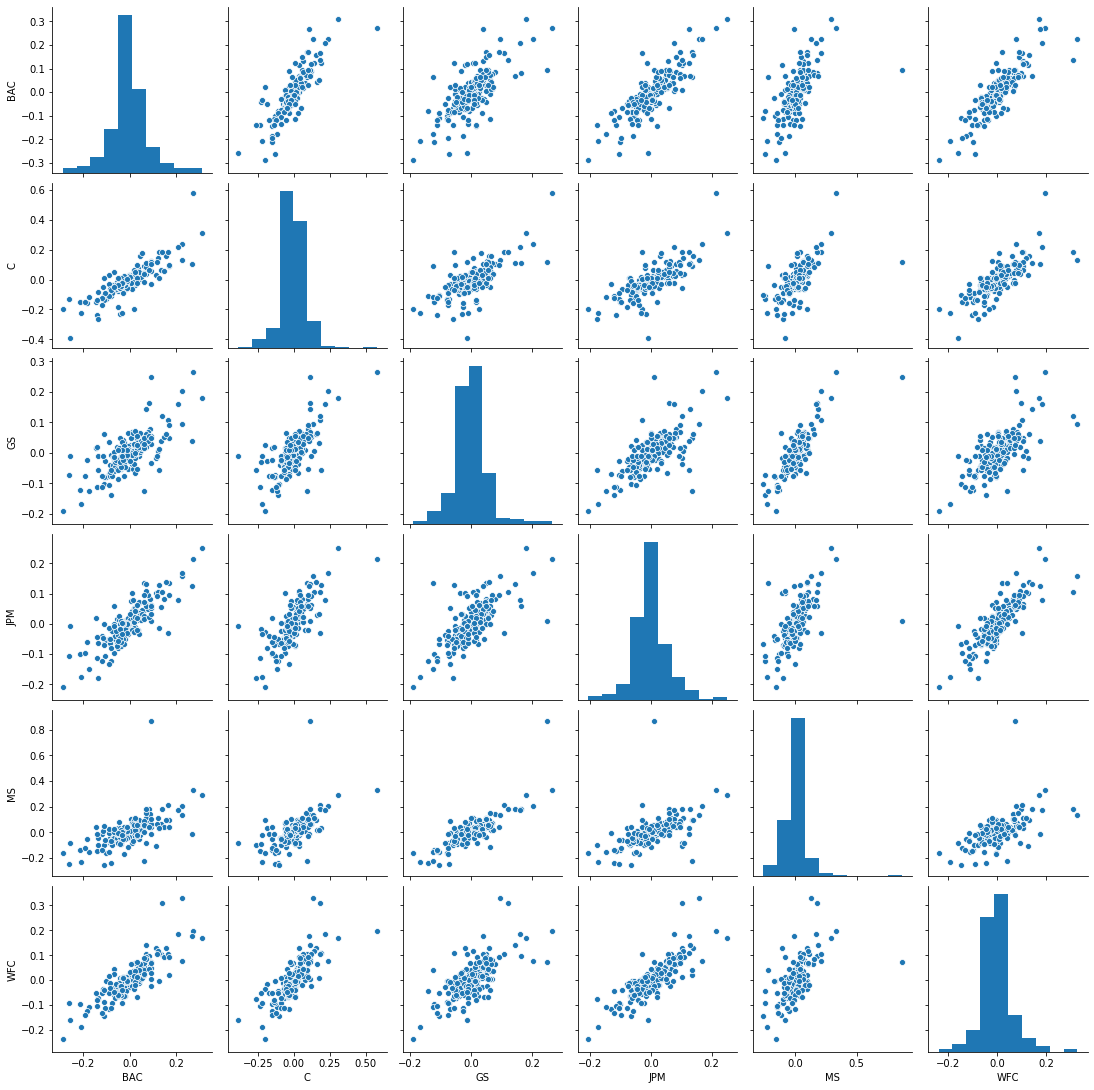

In [16]:
sns.pairplot(returns)
plt.show()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D2BEEB8BC8>,
      dtype=object)

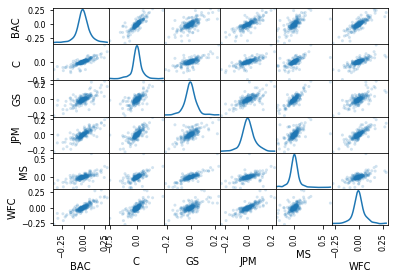

In [17]:

scatter_matrix(logreturns, alpha=0.2, diagonal="kde")

## 3.2 Pick at least 2 of your series.  Show the values (prices, yields) at least 6 months prior to the crisis, and at least 6 months after the crisis 'starts'.

In [19]:
#to be done

# 4. Data Summaries.   Extreme Values
## 4.1 Compute means.  Compute the 5% trimmed mean.  What points were considered outliers?

In [19]:
metrics = pd.DataFrame()
metrics['mean'] = returns.mean() 
metrics['trim_mean'] = stats.trim_mean(returns, 0.05)
display(metrics)

,mean,trim_mean
Name,,
BAC,-0.005600,-0.006653
C,-0.006761,-0.007638
GS,-0.000926,-0.002770
JPM,-0.000392,-0.001242
MS,0.000940,-0.002299
WFC,-0.001277,-0.003186


## 4.2 Compute the inter-quartile range.  Compute the standard deviation.  How do these relate?

The interquartile range (IQR) is the difference between the 75th and 25th percentile of the data also known as a robust measure of scale. It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers. 

These robust estimator typically have inferior statistical efficiency compared to conventional estimators for data drawn from a distribution without outliers.

In [20]:
iqr_ = []
for col in returns.columns:
  iqr_.append(stats.iqr(returns[col].dropna()))

metrics['inter-quartile range'] = iqr_
metrics['std_dev'] = returns.std() 
metrics[['inter-quartile range', 'std_dev']]

,inter-quartile range,std_dev
Name,,
BAC,0.068585,0.080457
C,0.071970,0.089872
GS,0.044533,0.055517
JPM,0.054649,0.059408
MS,0.066208,0.093326
WFC,0.054744,0.064772


## 4.3 Compute the skewness of each series

The skewness is computed below in section 4.4

## 4.4 Compute the median of each series.  Compare to the mean.  Compare this difference to the skewness.

Briefly speaking, the median is the value that splits the individual data set into two halves: the (approximately) 50% largest and 50% lowest. 
While mean is average value, i.e. is equal to the sum of all the values in the data set divided by the number of values in the data set. Mean is also refrenced as "representative" or central tendency. 

The skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean:

$$ \bar \mu_3 = \frac{ \sum_i^N (X_i - \bar X)^3}{ (N-1) \sigma^3} $$


The median is called “robust against outliers“, whereas the mean actually is “sensitive to outliers“.
Another time when when it's usually prefered the median over the mean (or mode) is when the data is skewed (i.e., the frequency distribution for our data is skewed)


In [21]:
metrics['median'] = returns.median()
metrics['skewness'] = returns.skew() 
metrics['diff_mean_and_median'] = (metrics['mean'] - metrics['median'])
metrics[['median','mean', 'diff_mean_and_median', 'skewness']]

,median,mean,diff_mean_and_median,skewness
Name,,,,
BAC,-0.009504,-0.005600,0.003904,0.302224
C,-0.007576,-0.006761,0.000815,0.847975
GS,-0.003548,-0.000926,0.002622,0.922192
JPM,-0.005921,-0.000392,0.005529,0.410038
MS,-0.000463,0.000940,0.001403,3.277389
WFC,-0.005228,-0.001277,0.003951,0.959478



* when mean is greater than median - skewness is negative, meaning the left tail is longer
* when mean is less than median - skewness is positive, - right tail is longer
* when mean is equal to median, skewness is 0, even though 
the skewness of normal distribution is also 0, this can not be used as fact of normal distribution of data set.

## 4.5 Compute the kurtosis. Bootstrap the standard deviation.  How does the volatility of the standard deviations estimate compare to the kurtosis?

First of all, kurtosis is a measure of the "tailedness"
$$ \mu_4 = \frac{ \sum_i^N (X_i - \bar X)^4}{ (N-1) \sigma^4} $$

In other words the smaller standard deviation the bigger kurtosis i.e. higher peak. But in the real world, the standard deviation of population $\sigma$ is always unknown, so the most common measurement is to find out how accurate it can be estimated. 

The core idea of bootstrap technique is to make certain kinds of statistical inferences based on the accuracy of estimates by calculating standard error.

We will use empirical distribution function (EDF) for sampling the population and calculate kurtosis independently for each sampled index and then calculate standard error.

In [22]:
def index_kurtosis(df):
     return stats.kurtosis(df)

se = []
# independently sample each index from data frame and calculate std error
for index in returns.columns:
  index_return = returns[index]
  index_dist = bp.EmpiricalDistribution(index_return)
  index_dist.sample(reset_index=False)
  se.append(bp.standard_error(index_dist, index_kurtosis))
 
# pandas calculates kurtosis of normal distibution as 0.0
metrics['excess_kurtosis'] = returns.kurtosis() 
metrics['std_kurtosis_error'] = se
metrics[['excess_kurtosis', 'std_kurtosis_error']]

,excess_kurtosis,std_kurtosis_error
Name,,
BAC,2.952949,0.560069
C,8.773879,3.719900
GS,4.975320,1.168430
JPM,2.557559,0.728540
MS,30.578549,14.534629
WFC,5.335763,1.744915


## 4.6 What do these metrics infer about the data generation process?

In our case standard error of the estimates is quite big which could be a sign of stong depnedancy on outliers. At the same time all indexes execess kurtosis of normal distribution.

# 5. Data Modeling
## 5.1 Pick 1 of the returns distributions.  Does a normal distribution fit this well?  Why or why not?

We will pick Goldman Sachs 'GS' stock. This is because the firm has a fairly stable base and has been in existence for well over a century, surviving almost much as an empire.

For normality test we will use D’Agostino’s K-squared test which is based on kurtosis and skewness


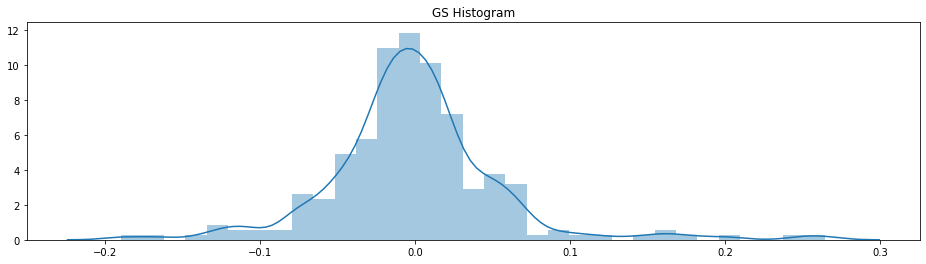

GS kurtosis: 4.975; skewness = 0.922
GS normal test statistic = 62.59719; pvalue = 0.00000
GS returns not normaly distributed


In [44]:
from scipy.stats import normaltest

selected_index1 = 'GS'

significance_level = 0.05

def plot_hist(index_name):
  selected_return = returns[index_name]
  fig, ax = plt.subplots(1,1, figsize=(16,4))
  sns.distplot(selected_return, ax = ax)
  ax.set_title('%s Histogram' % index_name)
  ax.set_xlabel(None)
  plt.show()

def print_normaltest_result(index_name):
  selected_return = returns[index_name]
  statistic, pvalue = normaltest(selected_return) 
  print('%s kurtosis: %.3f; skewness = %.3f' % ( index_name,
           metrics.at[index_name, 'excess_kurtosis'], 
           metrics.at[index_name, 'skewness']))
  print('%s normal test statistic = %.5f; pvalue = %.5f' % ( index_name,
                                                         statistic, pvalue))
  if pvalue > significance_level:
    print('Probably, %s returns are normally distributed' % index_name)
  else:
    print('%s returns not normaly distributed' % index_name)


plot_hist(selected_index1)
print_normaltest_result(selected_index1)


Null hypothesis using skewness/kurtosis testing showed that returns for GS are not normally distributed

## 5.1 Pick a 2nd security's return distributions.  Repeat: Does a normal distribution fit this well?  Why or why not?

A second security we will pick is J P Morgan (Ticker - 'JPM'). This is because JPM had some pretty bad positions which undermined the tail-losses from the payoff (more literature on which can be easily searched upon internet). 

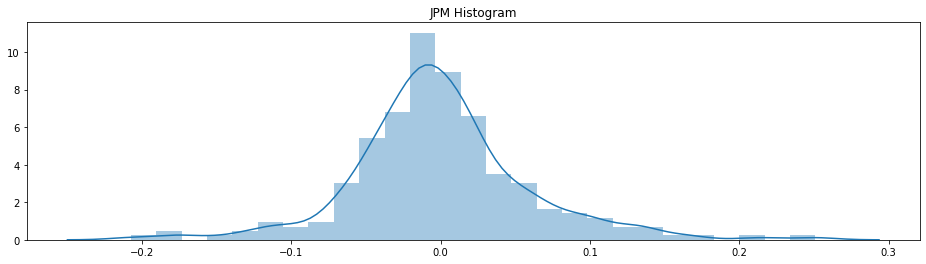

JPM kurtosis: 2.558; skewness = 0.410
JPM normal test statistic = 25.79613; pvalue = 0.00000
JPM returns not normaly distributed


In [45]:
selected_index2 = 'JPM'
plot_hist(selected_index2)
print_normaltest_result(selected_index2)

Null hypothesis testing using skewness/kurtosis showed that returns for JPM are not normally distributed 

## 5.3 Find heavy-tailed distributions that can fit your choices from 4.1 and 4.2

The most heavy tailed index : JPM


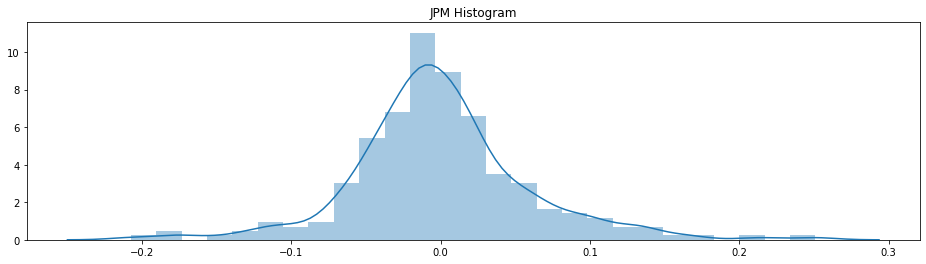

JPM kurtosis: 2.558; skewness = 0.410
JPM normal test statistic = 25.79613; pvalue = 0.00000
JPM returns not normaly distributed


In [46]:
heavy_tail_kurtosis = metrics['excess_kurtosis'].idxmin()
print('The most heavy tailed index : %s' % heavy_tail_kurtosis )
plot_hist(heavy_tail_kurtosis)
print_normaltest_result(heavy_tail_kurtosis)

## 5.4 For each of the series you modeled, which fits better: the Gaussian distribution of the heavy-tailed distribution.  Justify your reasoning.

For each of the series modeled, we observed that the heavy tailed distribution fit better. The series analyzed above revealed that returns were not normally distributed.

# 6. Modelling Before and After The Crisis
##6.1  Run any model from econometrics: LS, ARMA, GARCH, Cointegration, to model the bhevaior of the series PRIOR to the crisis

### Generalized Autoregressive Conditional Heteroskedasticity (GARCH)
GARCH extends ARCH by allowing the variance to depend on its own lags and the lags of the squared residuals. GARCH can capture greater changes like increasing and decreasing volatility. 

$$\sigma^2_t=\alpha_0+\alpha_1u^2_{t-1}+\alpha_2u^2_{t-2}+...+\alpha_pu^2_{t-p}+\beta_1\sigma^2_{t-1}+...+\beta_p\sigma^2_{t-q}$$

We have two parameters for GARCH(q, p):
* $q$: Number of lag variances
* $p$: Number of lag residual errors 

The parameters we're using here are consistent with the ARCH python library but more often the swapped notation is used. 

GARCH often fits data better than ARCH when there's heteroskedasticity and volatility clustering. We will perform an analysis with both GARCH and ARCH and explain the results but there are lots of variations on the GARCH model that introduce new parameters for the specific behaviors of volatility. 


Below we run some key statistics on the pre and post crisis datasets. We also apply the ADF test and run a simple VAR model prior to implementing ARCH/GARCH models.

In [24]:
pre_crisis = returns.query('Date < "2008-9-1"')
post_crisis = returns.query('Date >= "2008-9-1"')

In [25]:
display(pre_crisis)

Name,BAC,C,GS,JPM,MS,WFC
Date,,,,,,
2008-03-03,-0.014091,-0.026150,-0.026823,-0.020418,-0.012820,-0.012316
2008-03-04,-0.010209,-0.042876,-0.008965,-0.015822,-0.005532,-0.001385
2008-03-05,-0.015470,0.002262,0.008373,-0.011482,0.002902,0.005203
2008-03-06,-0.027430,-0.044244,-0.038309,-0.035364,-0.043405,-0.039683
2008-03-07,0.006024,-0.012281,0.008950,0.005084,0.004789,0.010061
...,...,...,...,...,...,...
2008-08-25,-0.041377,-0.029217,-0.025656,-0.040881,-0.017228,-0.023502
2008-08-26,0.002072,0.013061,0.001284,0.013286,0.009419,0.000698
2008-08-27,0.021709,0.015695,-0.002758,0.014477,0.012182,0.007668


In [26]:
display(post_crisis)

Name,BAC,C,GS,JPM,MS,WFC
Date,,,,,,
2008-09-02,0.047849,0.006320,0.008232,0.012990,0.011511,0.031054
2008-09-03,0.030322,0.026164,0.013852,0.018466,0.021066,-0.006408
2008-09-04,-0.071602,-0.066803,-0.040033,-0.045329,-0.043396,-0.043212
2008-09-05,0.053268,0.042076,0.014543,0.044579,0.025285,0.051567
2008-09-08,0.077567,0.065548,0.039757,0.049242,0.046180,0.075641
...,...,...,...,...,...,...
2009-02-23,0.031662,0.097436,-0.053434,-0.019598,-0.031395,0.010999
2009-02-24,0.209719,0.214953,0.161234,0.077396,0.172689,0.183137
2009-02-25,0.090909,-0.030769,-0.032910,0.033778,-0.014046,0.029885


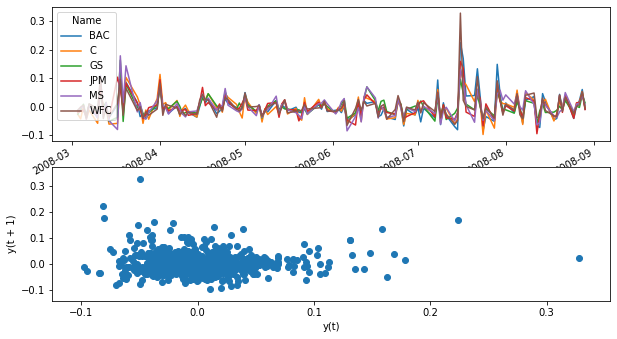

In [27]:
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(10,6))
pre_crisis.plot(ax=ax1)
pd.plotting.lag_plot(pre_crisis)
plt.show()

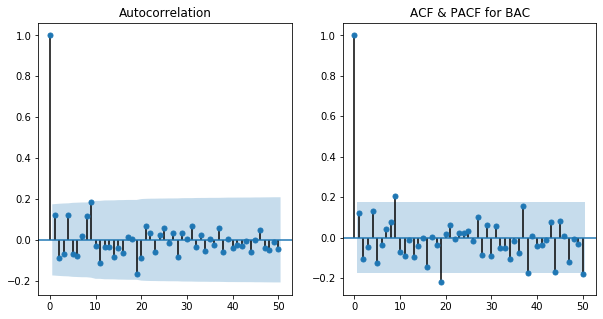

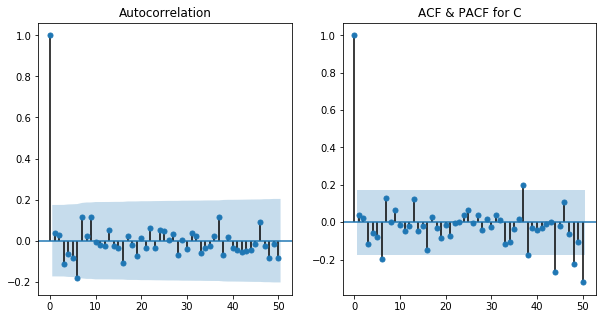

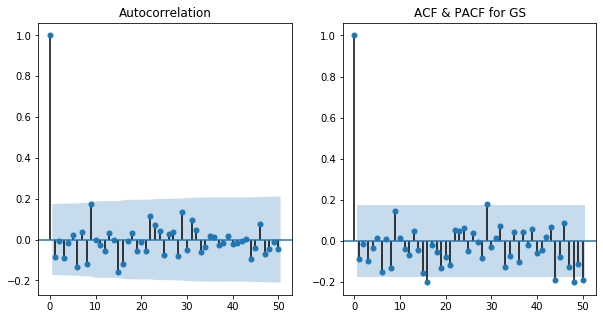

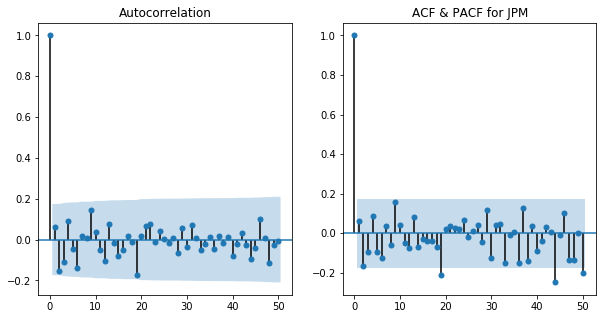

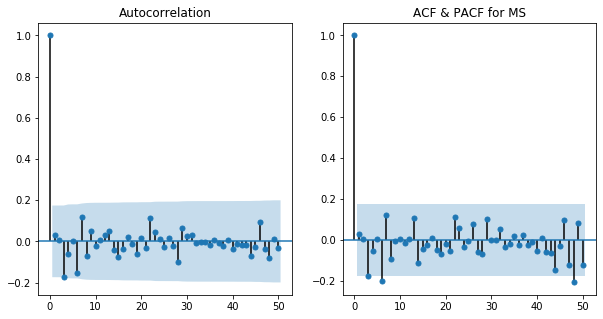

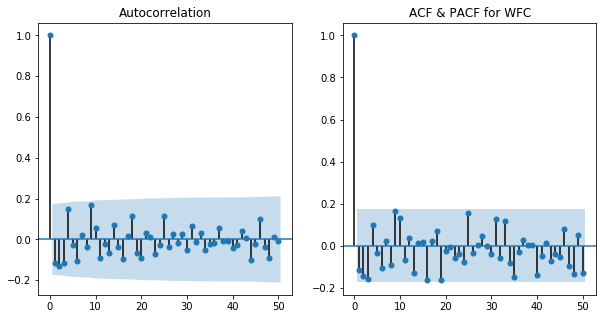

In [47]:
# plots the autocorrelation plots at 50 lags
# plt.figure()
for idx, col in enumerate(pre_crisis.columns):
  fig, ax = plt.subplots(1,2,figsize=(10,5))
  sm.graphics.tsa.plot_acf(pre_crisis[col], lags = 50, ax=ax[0])
  sm.graphics.tsa.plot_pacf(pre_crisis[col], lags = 50, ax=ax[1])
  plt.title('ACF & PACF for %s' % col) 
  plt.show()

In [28]:
def augmented_dickey_fuller_statistics(time_series):
  result = adfuller(time_series)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [33]:
for col in pre_crisis.columns:
  print('Augmented Dickey-Fuller Test: for %s' % col)
  augmented_dickey_fuller_statistics(pre_crisis[col])  

Augmented Dickey-Fuller Test: for BAC
ADF Statistic: -8.101049
p-value: 0.000000
Critical Values:
	1%: -3.484
	5%: -2.885
	10%: -2.579
Augmented Dickey-Fuller Test: for C
ADF Statistic: -10.764217
p-value: 0.000000
Critical Values:
	1%: -3.484
	5%: -2.885
	10%: -2.579
Augmented Dickey-Fuller Test: for GS
ADF Statistic: -8.155715
p-value: 0.000000
Critical Values:
	1%: -3.484
	5%: -2.885
	10%: -2.579
Augmented Dickey-Fuller Test: for JPM
ADF Statistic: -7.622042
p-value: 0.000000
Critical Values:
	1%: -3.485
	5%: -2.885
	10%: -2.579
Augmented Dickey-Fuller Test: for MS
ADF Statistic: -7.620472
p-value: 0.000000
Critical Values:
	1%: -3.484
	5%: -2.885
	10%: -2.579
Augmented Dickey-Fuller Test: for WFC
ADF Statistic: -9.468772
p-value: 0.000000
Critical Values:
	1%: -3.484
	5%: -2.885
	10%: -2.579


In [127]:
test_size = 26
X_train, X_test = pre_crisis[0:-test_size],pre_crisis[-test_size:]

# Check Size
print(X_train.shape)
print(X_test.shape)

(101, 6)
(26, 6)


In [109]:
maxlag=2
test = 'ssr-chi2test'
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train, variables = X_train.columns)

,BAC_x,C_x,GS_x,JPM_x,MS_x,WFC_x
BAC_y,1.0000,0.1293,0.1830,0.2531,0.2833,0.0435
C_y,0.0388,1.0000,0.5230,0.0009,0.3813,0.0564
GS_y,0.2477,0.8798,1.0000,0.0000,0.8063,0.0397
JPM_y,0.2627,0.0488,0.0888,1.0000,0.3186,0.0756
MS_y,0.2007,0.3022,0.7162,0.0001,1.0000,0.0434
WFC_y,0.1465,0.0437,0.2354,0.3332,0.1324,1.0000


In [110]:

#Initiate VAR model
model = VAR(endog=X_train)
res = model.select_order(2)
res.summary()

,AIC,BIC,FPE,HQIC
0,-45.33,-45.17*,2.061e-20,-45.26
1,-45.99*,-44.88,1.070e-20*,-45.54*
2,-45.70,-43.66,1.434e-20,-44.87


In [111]:
#Fit to a VAR model
model_fit = model.fit(maxlags=2)
#Print a summary of the model results
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 28, Apr, 2021
Time:                     00:34:46
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -43.6558
Nobs:                     99.0000    HQIC:                  -44.8732
Log likelihood:           1497.32    FPE:                1.43391e-20
AIC:                     -45.7005    Det(Omega_mle):     6.83949e-21
--------------------------------------------------------------------
Results for equation BAC
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.001736         0.004543           -0.382           0.702
L1.BAC        -0.019305         0.305451           -0.063           0.950
L1.C          -0.369847         0.285247           -1.297           0.195
L1.GS         -0

In [112]:
# Get the lag order
lag_order = model_fit.k_ar
print(lag_order)
# Input data for forecasting
input_data = X_train.values[-lag_order:]

# forecasting
pred = model_fit.forecast(y=input_data, steps=test_size)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print(pred)

2
Name        BAC_pred    C_pred   GS_pred  JPM_pred   MS_pred  WFC_pred
Date                                                                  
2008-07-25  0.010499 -0.001800  0.006797  0.014885  0.007678  0.015459
2008-07-28 -0.014935 -0.003488  0.001563  0.004787 -0.002382  0.003104
2008-07-29  0.002815  0.002880  0.008779  0.005187  0.007049  0.006038
2008-07-30 -0.002270  0.000990 -0.000931 -0.000721  0.000845 -0.001510
2008-07-31 -0.001618 -0.000116  0.000881  0.000683 -0.000866  0.000714
2008-08-01 -0.001540 -0.000777  0.002015  0.000772 -0.000485  0.000605
2008-08-04 -0.001363 -0.000899  0.001363  0.000514 -0.000074  0.001338
2008-08-05 -0.000688 -0.000502  0.001473  0.001285  0.000245  0.001583
2008-08-06 -0.000959 -0.000404  0.001680  0.001153  0.000182  0.001268
2008-08-07 -0.001062 -0.000482  0.001609  0.000882  0.000048  0.001227
2008-08-08 -0.001028 -0.000545  0.001494  0.000916 -0.000008  0.001245
2008-08-11 -0.001007 -0.000541  0.001542  0.000989  0.000038  0.001285
2008

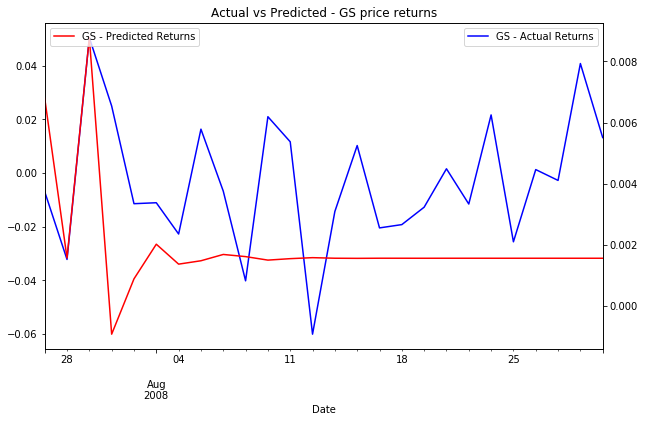

In [128]:
plt.figure(figsize=(10,6))

ax1 = X_test.GS.plot(color='b', label="GS - Actual Returns")
ax2 = pred.GS_pred.plot(color='r', secondary_y=True, label="GS - Predicted Returns")

ax1.legend(loc=1)
ax2.legend(loc=2)

plt.title("Actual vs Predicted - GS price returns")
plt.show()

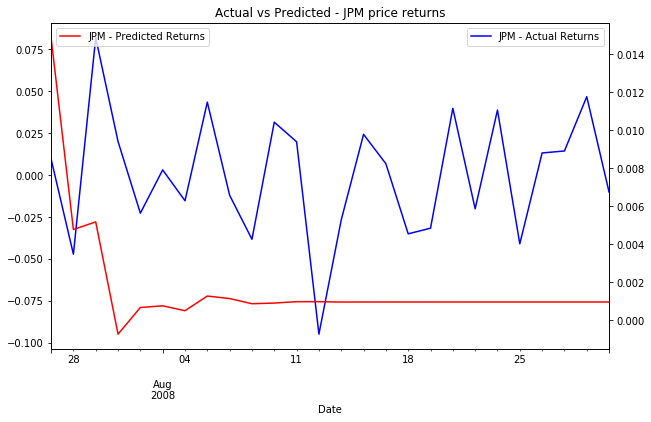

In [129]:
plt.figure(figsize=(10,6))

ax1 = X_test.JPM.plot(color='b', label="JPM - Actual Returns")
ax2 = pred.JPM_pred.plot(color='r', secondary_y=True, label="JPM - Predicted Returns")

ax1.legend(loc=1)
ax2.legend(loc=2)

plt.title("Actual vs Predicted - JPM price returns")
plt.show()

In [130]:
#Calculate forecast bias
forecast_errors = [X_test['GS'][i]- pred['GS_pred'][i] for i in range(len(X_test['GS']))]
bias = sum(forecast_errors) * 1.0/len(X_test['GS'])
print('Bias: %f' % bias)
#Calculate mean absolute error
mae = mean_absolute_error(X_test['GS'],pred['GS_pred'])
print('MAE: %f' % mae)
#Calculate mean squared error and root mean squared error
mse = mean_squared_error(X_test['GS'], pred['GS_pred'])
print('MSE: %f' % mse)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

Bias: -0.005193
MAE: 0.019958
MSE: 0.000594
RMSE: 0.024372


In [131]:
#Calculate forecast bias
forecast_errors = [X_test['JPM'][i]- pred['JPM_pred'][i] for i in range(len(X_test['JPM']))]
bias = sum(forecast_errors) * 1.0/len(X_test['JPM'])
print('Bias: %f' % bias)
#Calculate mean absolute error
mae = mean_absolute_error(X_test['JPM'],pred['JPM_pred'])
print('MAE: %f' % mae)
#Calculate mean squared error and root mean squared error
mse = mean_squared_error(X_test['JPM'], pred['JPM_pred'])
print('MSE: %f' % mse)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

Bias: -0.001685
MAE: 0.030148
MSE: 0.001354
RMSE: 0.036802


#### ARCH/GARCH Modelling to model volatility characteristics pre-crisis

We take the security (MS) with the most skew and try to see which distribution fits best for ARCH/GARCH models. The distribution that results in the greatest log-likelihood is the ideal distribution.

In [132]:
res_normal = arch_model(pre_crisis['MS']).fit(disp="off")
res_t = arch_model(pre_crisis['MS'], dist="t").fit(disp="off")
res_skewt = arch_model(pre_crisis['MS'], dist="skewt").fit(disp="off")
lls = pd.Series(
    OrderedDict(
        (
            ("normal", res_normal.loglikelihood),
            ("t", res_t.loglikelihood),
            ("skewt", res_skewt.loglikelihood),
        )
    )
)
print(lls)

normal    233.899933
t         237.554521
skewt     240.239856
dtype: float64


From the loglikelihoods above, it is evident that the skewed-t distribution is the most suitable distribution for MS, which is the most skewed distribution of all the returns.

Before we proceed, it is worth pointing out that since the ADF statistics found earlier are greater than the critical value for all cases, we do not need to worry about seasonal decomposition. 


We proceed with our ARCH and GARCH models.  For each security, we determine wheteher there is an added usefulness to implementing a GARCH Model. The Akaike Information Criterion will be our guide in comparing the models. Here we compare a simple ARCH(1) model to the GJR-GARCH model that accounts for asymmetric shocks on pre-recession data.

In [120]:
arch_results = {}
garch_results = {}

In [121]:
for ticker in returns:
    model_arch = arch_model(pre_crisis[ticker],  mean='Zero', vol='ARCH', dist='normal')
    arch_results[ticker] = model_arch.fit(disp='off')
    model_garch = arch_model(pre_crisis[ticker], mean='Zero', vol='GARCH', p=1, q=1, o=1, dist='normal')
    garch_results[ticker] = model_garch.fit(disp='off')
    print(20*'#')
    print(ticker)
    print(20*'#')

    print(f'\nARCH AIC: {arch_results[ticker].aic}')
    print(f'GJR-GARCH AIC: {garch_results[ticker].aic}')
    

####################
BAC
####################

ARCH AIC: -449.23801507685704
GJR-GARCH AIC: -475.97207514724903
####################
C
####################

ARCH AIC: -450.8296533181974
GJR-GARCH AIC: -458.94855024371674
####################
GS
####################

ARCH AIC: -521.5664542020022
GJR-GARCH AIC: -535.476471295064
####################
JPM
####################

ARCH AIC: -476.4927225652451
GJR-GARCH AIC: -481.62877728671435
####################
MS
####################

ARCH AIC: -452.63381739083786
GJR-GARCH AIC: -466.2103518535872
####################
WFC
####################

ARCH AIC: -445.1029626669454
GJR-GARCH AIC: -475.25126291972845


Based on the AIC coefficients, the GARCH model provided better generalization to our volatility.

Below we show the key parameters - alpha, beta and omega for each of the ARCH/GARCH models and other summary statistics. We plot the conditional volatility of our GARCH model agains the Price Returns to visualize the fit.

####################
BAC
####################
                        Zero Mean - ARCH Model Results                        
Dep. Variable:                    BAC   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.008
Vol Model:                       ARCH   Log-Likelihood:                226.619
Distribution:                  Normal   AIC:                          -449.238
Method:            Maximum Likelihood   BIC:                          -443.550
                                        No. Observations:                  127
Date:                Wed, Apr 28 2021   Df Residuals:                      127
Time:                        00:36:34   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1

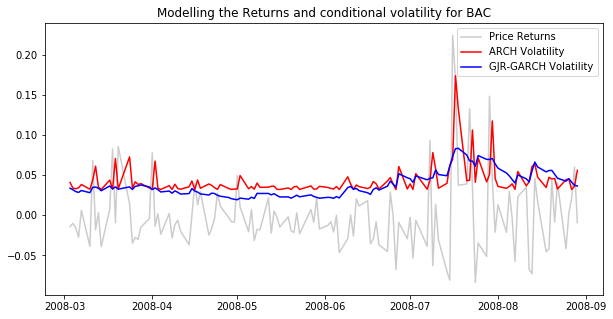

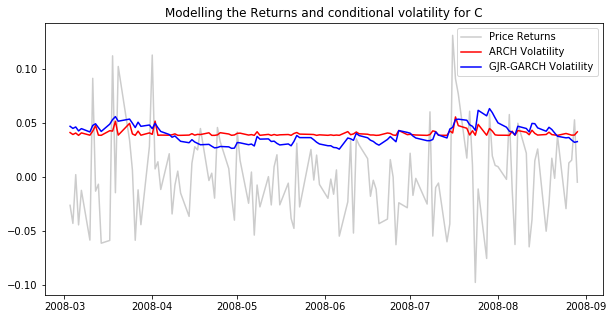

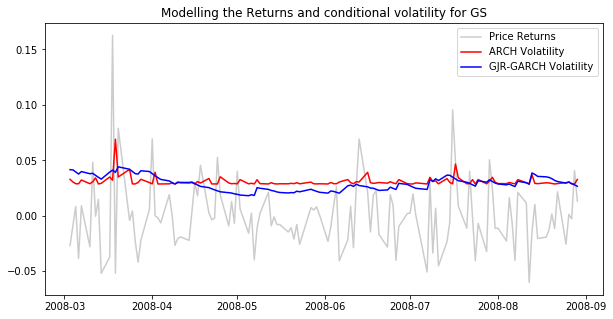

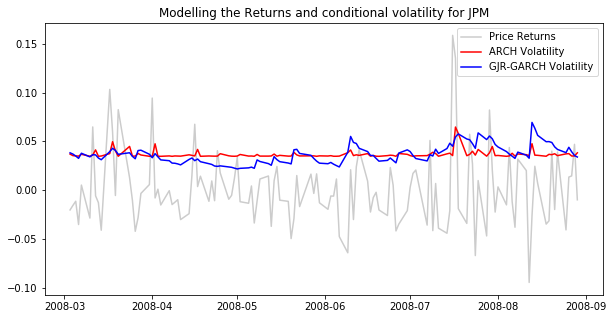

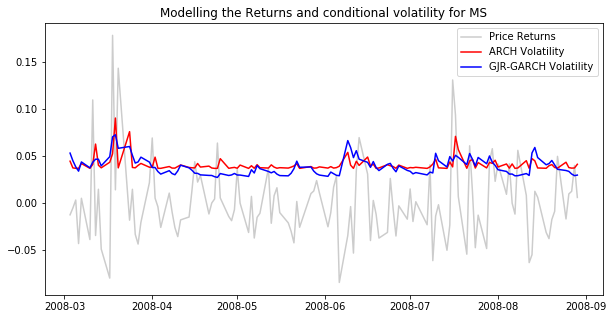

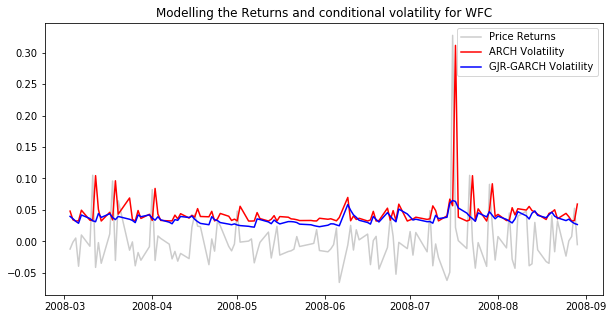

In [122]:
for ticker in returns:
    print(20*'#')
    print(ticker)
    print(20*'#')
    print(arch_results[ticker].summary())
    print(garch_results[ticker].summary())
    plt.figure(figsize=(10,5))
    plt.plot(pre_crisis[ticker], color='grey', alpha = 0.4, label = 'Price Returns')
    plt.plot(arch_results[ticker].conditional_volatility, color='red', label = 'ARCH Volatility')
    plt.plot(garch_results[ticker].conditional_volatility, color='blue', label = 'GJR-GARCH Volatility')
    plt.legend(loc = 'upper right')
    plt.title('Modelling the Returns and conditional volatility for %s' % ticker)

## 6.2 Run the same model, but only use the data after the crisis.

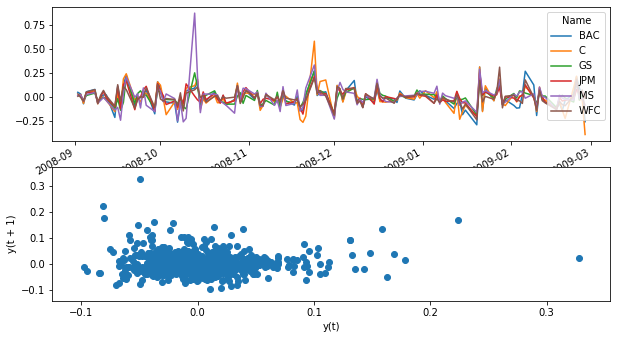

In [133]:
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(10,6))
post_crisis.plot(ax=ax1)
pd.plotting.lag_plot(pre_crisis)
plt.show()

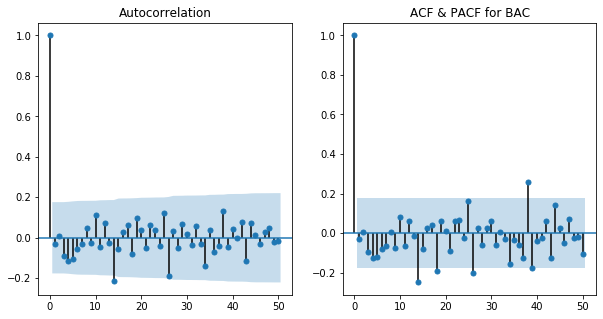

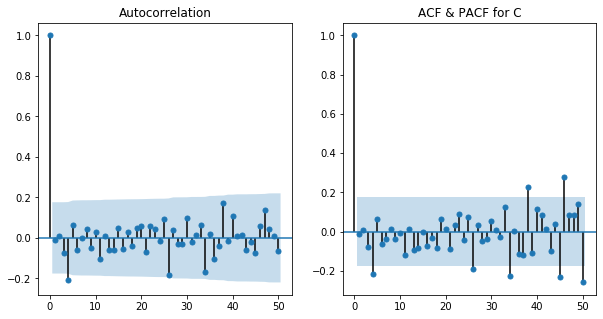

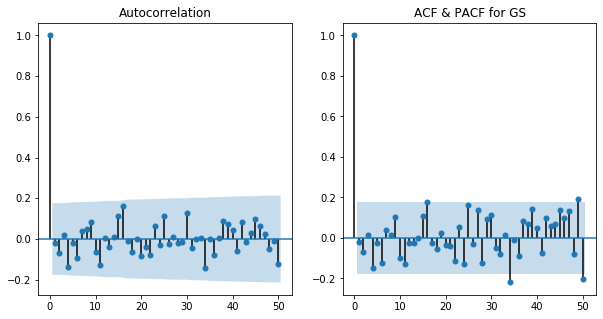

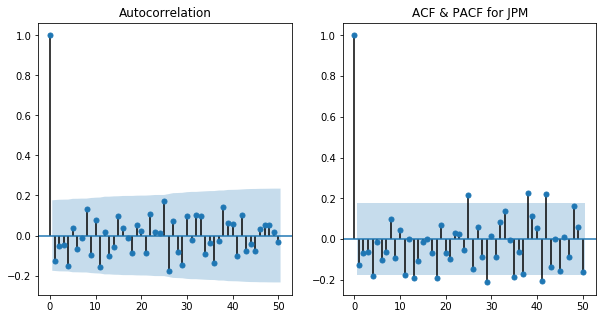

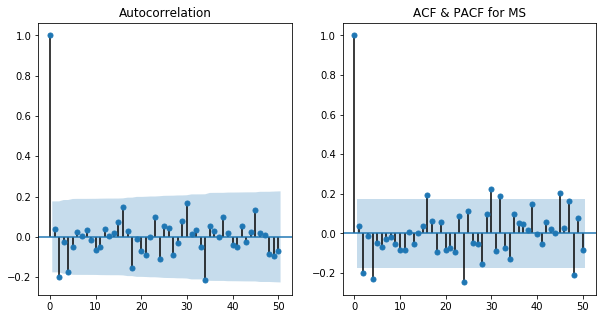

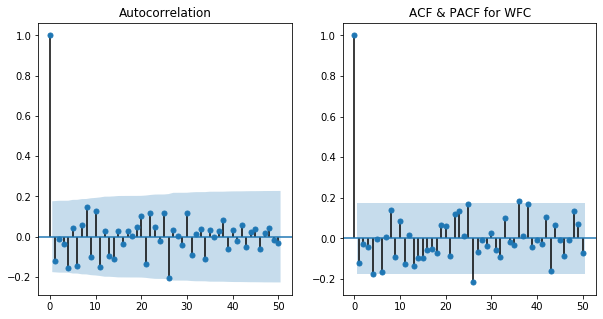

In [134]:
# plots the autocorrelation plots at 50 lags
# plt.figure()
for idx, col in enumerate(post_crisis.columns):
  fig, ax = plt.subplots(1,2,figsize=(10,5))
  sm.graphics.tsa.plot_acf(post_crisis[col], lags = 50, ax=ax[0])
  sm.graphics.tsa.plot_pacf(post_crisis[col], lags = 50, ax=ax[1])
  plt.title('ACF & PACF for %s' % col) 
  plt.show()

In [ ]:
for col in post_crisis.columns:
  print('Augmented Dickey-Fuller Test: for %s' % col)
  augmented_dickey_fuller_statistics(post_crisis[col])  

Augmented Dickey-Fuller Test: for BAC
ADF Statistic: -11.107749
p-value: 0.000000
Critical Values:
	1%: -3.485
	5%: -2.885
	10%: -2.579
Augmented Dickey-Fuller Test: for C
ADF Statistic: -10.690692
p-value: 0.000000
Critical Values:
	1%: -3.485
	5%: -2.885
	10%: -2.579
Augmented Dickey-Fuller Test: for GS
ADF Statistic: -11.240175
p-value: 0.000000
Critical Values:
	1%: -3.485
	5%: -2.885
	10%: -2.579
Augmented Dickey-Fuller Test: for JPM
ADF Statistic: -12.477691
p-value: 0.000000
Critical Values:
	1%: -3.485
	5%: -2.885
	10%: -2.579
Augmented Dickey-Fuller Test: for MS
ADF Statistic: -7.354599
p-value: 0.000000
Critical Values:
	1%: -3.486
	5%: -2.886
	10%: -2.580
Augmented Dickey-Fuller Test: for WFC
ADF Statistic: -12.256821
p-value: 0.000000
Critical Values:
	1%: -3.485
	5%: -2.885
	10%: -2.579


In [135]:
test_size = 24
X_train, X_test = post_crisis[0:-test_size],returns[-test_size:]

# Check Size
print(X_train.shape)
print(X_test.shape)

(100, 6)
(24, 6)


In [136]:
grangers_causality_matrix(X_train, variables = X_train.columns)

,BAC_x,C_x,GS_x,JPM_x,MS_x,WFC_x
BAC_y,1.0000,0.5959,0.1048,0.6306,0.0339,0.6528
C_y,0.7009,1.0000,0.3706,0.7194,0.1138,0.3800
GS_y,0.4435,0.3666,1.0000,0.2124,0.0021,0.5606
JPM_y,0.3835,0.6659,0.0792,1.0000,0.6833,0.0574
MS_y,0.2296,0.4804,0.0337,0.5952,1.0000,0.6355
WFC_y,0.4358,0.8319,0.0813,0.3881,0.5492,1.0000


In [137]:
#Initiate VAR model
model = VAR(endog=X_train)
res = model.select_order(2)
res.summary()

,AIC,BIC,FPE,HQIC
0,-34.56*,-34.40*,9.779e-16*,-34.50*
1,-34.45,-33.34,1.100e-15,-34.00
2,-34.29,-32.24,1.290e-15,-33.46


In [138]:
#Fit to a VAR model
model_fit = model.fit(maxlags=2)
#Print a summary of the model results
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 28, Apr, 2021
Time:                     00:39:01
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -32.2361
Nobs:                     98.0000    HQIC:                  -33.4614
Log likelihood:           924.047    FPE:                1.29004e-15
AIC:                     -34.2935    Det(Omega_mle):     6.10974e-16
--------------------------------------------------------------------
Results for equation BAC
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.011404         0.010684           -1.067           0.286
L1.BAC        -0.068483         0.275691           -0.248           0.804
L1.C           0.142443         0.175184            0.813           0.416
L1.GS         -0

In [139]:
# Get the lag order
lag_order = model_fit.k_ar
print(lag_order)
# Input data for forecasting
input_data = X_train.values[-lag_order:]

# forecasting
pred = model_fit.forecast(y=input_data, steps=test_size)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print(pred)

2
Name        BAC_pred    C_pred   GS_pred  JPM_pred   MS_pred  WFC_pred
Date                                                                  
2009-01-26 -0.085437 -0.054252 -0.043352 -0.027721 -0.042555 -0.055848
2009-01-27  0.002613 -0.010748  0.013485 -0.004553  0.058399  0.008326
2009-01-28 -0.025621 -0.029985 -0.011642 -0.023155 -0.002045 -0.015079
2009-01-29 -0.012630 -0.012447 -0.007028  0.003732 -0.018003  0.001775
2009-01-30 -0.016756 -0.018431 -0.006187 -0.001929 -0.006908 -0.005961
2009-02-02 -0.011402 -0.007856 -0.007025 -0.000937 -0.003088 -0.005738
2009-02-03 -0.012326 -0.010212 -0.005724 -0.000753  0.000626 -0.004818
2009-02-04 -0.011998 -0.011481 -0.005244 -0.002792  0.002590 -0.004645
2009-02-05 -0.012595 -0.011721 -0.005967 -0.002885 -0.000054 -0.004576
2009-02-06 -0.012500 -0.011838 -0.005784 -0.002064 -0.001021 -0.004168
2009-02-09 -0.012561 -0.011727 -0.005900 -0.002110 -0.001106 -0.004499
2009-02-10 -0.012411 -0.011320 -0.005913 -0.001955 -0.000893 -0.004522
2009

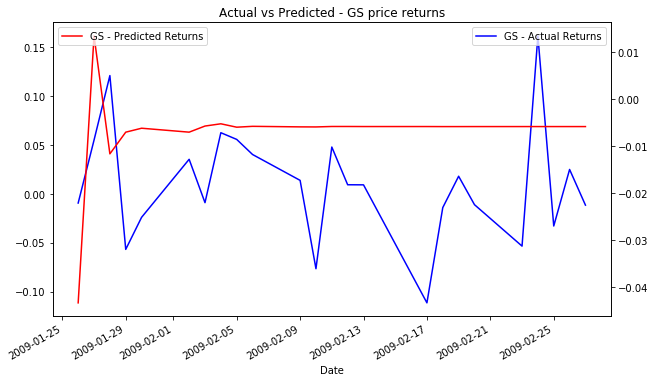

In [140]:
plt.figure(figsize=(10,6))

ax1 = X_test.GS.plot(color='b', label="GS - Actual Returns")
ax2 = pred.GS_pred.plot(color='r', secondary_y=True, label="GS - Predicted Returns")

ax1.legend(loc=1)
ax2.legend(loc=2)

plt.title("Actual vs Predicted - GS price returns")
plt.show()

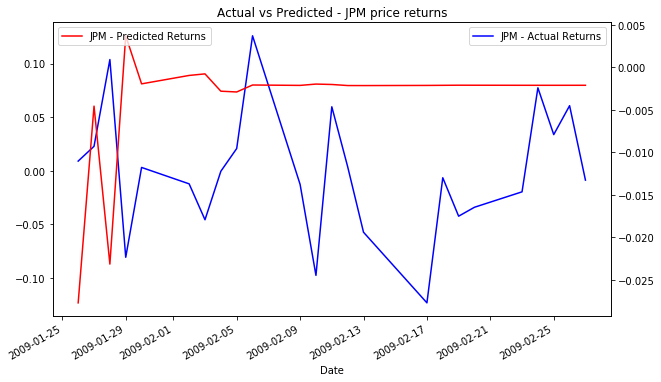

In [141]:
plt.figure(figsize=(10,6))

ax1 = X_test.JPM.plot(color='b', label="JPM - Actual Returns")
ax2 = pred.JPM_pred.plot(color='r', secondary_y=True, label="JPM - Predicted Returns")

ax1.legend(loc=1)
ax2.legend(loc=2)

plt.title("Actual vs Predicted - JPM price returns")
plt.show()

In [142]:
#Calculate forecast bias
forecast_errors = [X_test['GS'][i]- pred['GS_pred'][i] for i in range(len(X_test['GS']))]
bias = sum(forecast_errors) * 1.0/len(X_test['GS'])
print('Bias: %f' % bias)
#Calculate mean absolute error
mae = mean_absolute_error(X_test['GS'],pred['GS_pred'])
print('MAE: %f' % mae)
#Calculate mean squared error and root mean squared error
mse = mean_squared_error(X_test['GS'], pred['GS_pred'])
print('MSE: %f' % mse)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

Bias: 0.016986
MAE: 0.045416
MSE: 0.003655
RMSE: 0.060458


In [143]:
#Calculate forecast bias
forecast_errors = [X_test['JPM'][i]- pred['JPM_pred'][i] for i in range(len(X_test['JPM']))]
bias = sum(forecast_errors) * 1.0/len(X_test['JPM'])
print('Bias: %f' % bias)
#Calculate mean absolute error
mae = mean_absolute_error(X_test['JPM'],pred['JPM_pred'])
print('MAE: %f' % mae)
#Calculate mean squared error and root mean squared error
mse = mean_squared_error(X_test['JPM'], pred['JPM_pred'])
print('MSE: %f' % mse)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

Bias: 0.003034
MAE: 0.046640
MSE: 0.003740
RMSE: 0.061158


We repeat the volatility modelling as carried for the pre-crisis data.

####################
BAC
####################
                        Zero Mean - ARCH Model Results                        
Dep. Variable:                    BAC   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.008
Vol Model:                       ARCH   Log-Likelihood:                105.545
Distribution:                  Normal   AIC:                          -207.091
Method:            Maximum Likelihood   BIC:                          -201.450
                                        No. Observations:                  124
Date:                Wed, Apr 28 2021   Df Residuals:                      124
Time:                        00:39:24   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      9

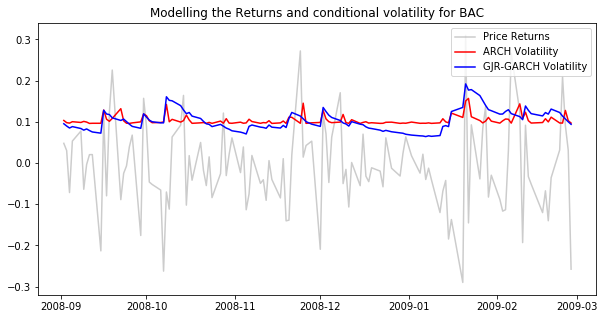

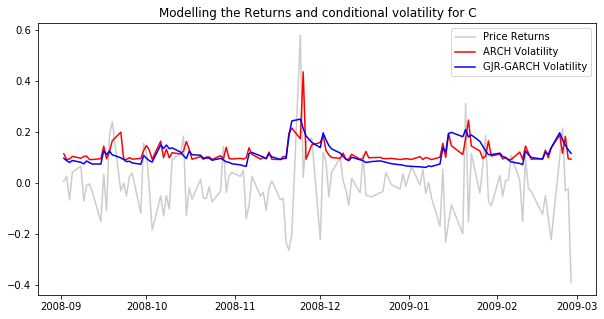

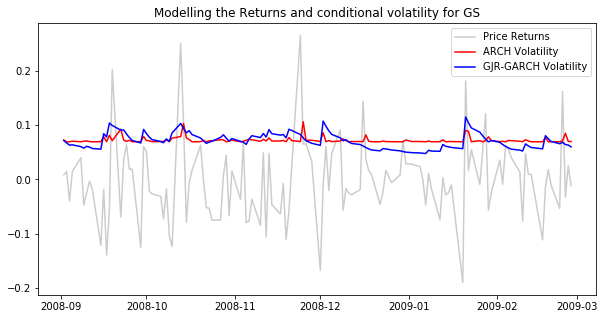

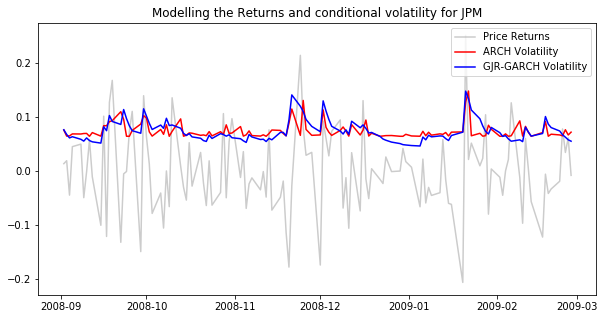

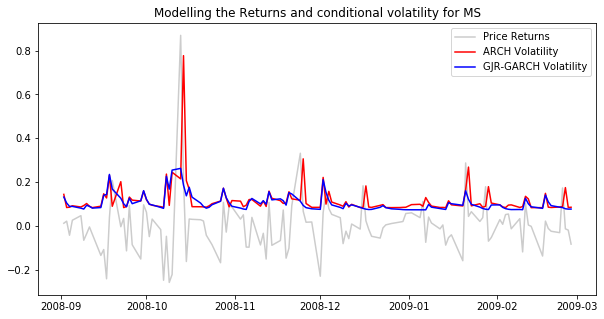

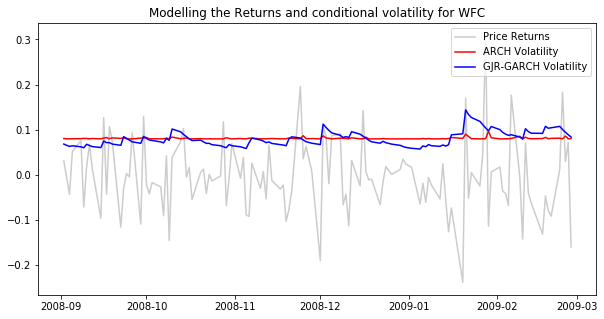

In [144]:
for ticker in returns:
    model_arch = arch_model(post_crisis[ticker],  mean='Zero', vol='ARCH', dist='normal')
    arch_results[ticker] = model_arch.fit(disp='off')
    model_garch = arch_model(post_crisis[ticker], mean='Zero', vol='GARCH', p=1, q=1, o=1, dist='normal')
    garch_results[ticker] = model_garch.fit(disp='off')
    print(20*'#')
    print(ticker)
    print(20*'#')
    print(arch_results[ticker].summary())
    print(garch_results[ticker].summary())
    plt.figure(figsize=(10,5))
    plt.plot(post_crisis[ticker], color='grey', alpha = 0.4, label = 'Price Returns')
    plt.plot(arch_results[ticker].conditional_volatility, color='red', label = 'ARCH Volatility')
    plt.plot(garch_results[ticker].conditional_volatility, color='blue', label = 'GJR-GARCH Volatility')
    plt.legend(loc = 'upper right')
    plt.title('Modelling the Returns and conditional volatility for %s' % ticker)

## 6.3 Using Hurst Exponent to determine any mean reversion behaviors

In [145]:
def hurst_exponent(df):
    ts = df.values
    lags = range(2, 100)   
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]*2.0

In [146]:
hurst_list = []

In [147]:
for ticker in returns:
    hurst_list.append([hurst_exponent(pre_crisis[ticker]),\
    hurst_exponent(post_crisis[ticker]),\
    hurst_exponent(returns[ticker])])

In [148]:
hurst_df = pd.DataFrame(hurst_list, index=returns.columns, columns = ['Pre-Crisis', 'Post-Crisis', 'All Returns'])
hurst_df

,Pre-Crisis,Post-Crisis,All Returns
Name,,,
BAC,0.020164,0.026343,0.002028
C,0.029053,-0.026896,-0.012548
GS,0.033559,-0.016643,0.003301
JPM,0.020634,-0.007984,0.000457
MS,0.030623,-0.016821,0.019169
WFC,0.013643,0.019313,-0.001973


Hurst exponents can be used to interpret the data as mean reverting (when the exponent is close to 0), brownian motion/random walk (when the exponent is close to 0.5) or trending (when the exponent is close to 1).

While it is uncharacteristic that the exponents are negative, just from the implementation and the math - it can be quickly observed that in short durations the hurst exponent may take a negative value. 

While Pre-Crisis we see some brownian motion characteristics for some tickers, post crisis the returns were generally mean reverting. Over our entire dataset, the hurst exponents close to 0 indicate strong mean reversion characteristics.